In [58]:
import holoviews as hv
import holoviews.util
#hv.extension('bokeh')
from matplotlib import colors
hv.extension('matplotlib')
%output fig='pdf'

import numpy as np
import cPickle
import yt
import matplotlib.pyplot as pl
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
from emission_functions import *
import pandas as pd
import datashader as dshade
import matplotlib.pyplot as plt

from holoviews.operation.datashader import aggregate, datashade, dynspread, shade
from holoviews.operation import decimate
from holoviews.operation import histogram
from holoviews import Store

In [2]:
def make_radius_array(rb_width,frbarr):
    box_size = rb_width/2.
    num_cells = frbarr.shape[0]
    xL = np.linspace(-1*box_size,box_size,num_cells)
    xL2,yL = np.meshgrid(xL,xL)
    r = abs(xL2+1j*yL)
    return r 

## Perfecting Radial Profiles with Holoviews + Datashader

In [3]:
base = "/Users/dalek/data/Molly/nref11n_nref10f_refine200kpc_z4to2"
fn = base+"/RD0020/RD0020"
lines = ['HAlpha','OVI','CIV','CIII_977','SiIV']
track_name = base+"/halo_track"
args = fn.split('/')

ds = yt.load(fn)
track = Table.read(track_name, format='ascii')
track.sort('col1')
rb,rb_center,rb_width = get_refine_box(ds,ds.current_redshift,track)
redshift = ds.current_redshift

box_width = ds.arr(rb_width,'code_length').in_units('kpc')

yt : [INFO     ] 2018-02-15 12:55:42,024 Parameters: current_time              = 154.801032717
yt : [INFO     ] 2018-02-15 12:55:42,024 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-02-15 12:55:42,026 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-02-15 12:55:42,027 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2018-02-15 12:55:42,028 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-02-15 12:55:42,029 Parameters: current_redshift          = 1.99999968795
yt : [INFO     ] 2018-02-15 12:55:42,031 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2018-02-15 12:55:42,032 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2018-02-15 12:55:42,033 Parameters: hubble_constant           = 0.695


using this loc:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.04999996364 0.493091 0.488119 0.501099 0.495091 0.490119 0.503099   10


In [4]:
natural_base = '_nref11_RD0020_'
refined_base = '_nref11n_nref10f_refine200kpc_z4to2_RD0020_'
box_size = ds.arr(rb_width,'code_length').in_units('kpc')
res_list = [0.2,1,5,10]
lines = ['CIII_977','OVI']

In [5]:
field = 'Emission_CIII_977'
fileinNAT = 'frbs/frb'+'x'+natural_base+field+'_forcedres.cpkl'
fileinREF = 'frbs/frb'+'x'+refined_base+field+'_forcedres.cpkl'

frbNAT = cPickle.load(open(fileinNAT,'rb'))
frbREF = cPickle.load(open(fileinREF,'rb'))

frbNAT = np.log10(frbNAT/(1.+redshift)**4)
frbREF = np.log10(frbREF/(1.+redshift)**4)

r = make_radius_array(box_width,frbNAT)

In [8]:
emisREF = frbREF.flatten()
dist = r.flatten()
detect_prob = np.chararray(np.size(dist), 4)
detect_prob[emisREF >= 3] = 'definite'
detect_prob[((emisREF < 3) & (emisREF >= 2))] = 'probable'
detect_prob[((emisREF < 2) & (emisREF >= 1))] = 'possible'
detect_prob[emisREF < 1] = 'nope'
dfREF = pd.DataFrame({'dist':dist,'emisREF':emisREF,'detect_prob':detect_prob})
dfREF.detec_prob = dfREF.detect_prob.astype('category') 

#arrH = np.zeros((len(idH),2))
#arrH[:,0],arrH[:,1] = dist[idH],emisREF[idH]
#arrM = np.zeros((len(idM),2))
#arrM[:,0],arrM[:,1] = dist[idM],emisREF[idM]
#arrL = np.zeros((len(idL),2))
#arrL[:,0],arrL[:,1] = dist[idL],emisREF[idL]
#arrN = np.zeros((len(idN),2))
#arrN[:,0],arrN[:,1] = dist[idN],emisREF[idN]

In [9]:
print np.unique(dfREF['detect_prob'])

['defi' 'nope' 'poss' 'prob']


In [10]:
dtest = dist[0:1000]
etest = emisREF[0:1000]
dfTEST = pd.DataFrame({'dist':dtest,'emisREF':etest})

In [11]:
detect_color_key = {b'nope':'#808080',
                    b'poss':'#FF69B4',
                    b'prob':'#00CED1',
                    b'defi': '#32CD32'} #'#7FFF00'}

In [ ]:
#%%opts RGB [width=820] {+axiswise}

sb_point = hv.Points(dfREF,kdims=['dist','emisREF'],label='CIII 977') 
sb_shade = datashade(sb_point,color_key=detect_color_key,
                     aggregator=dshade.count_cat('detect_prob'),y_range=(-10,6),
                     dynamic=False).opts(plot=dict(aspect='square'))
sb_shade
#help(testout)

In [ ]:
from holoviews import Store
renderer = Store.renderers['matplotlib'].instance(fig='pdf', holomap='gif')
renderer.save(sb_shade, 'SBprof_test') 

In [ ]:
emisNAT = frbNAT.flatten()
dist = r.flatten()
detect_prob = np.chararray(np.size(dist), 4)
detect_prob[emisNAT >= 3] = 'definite'
detect_prob[((emisNAT < 3) & (emisNAT >= 2))] = 'probable'
detect_prob[((emisNAT < 2) & (emisNAT >= 1))] = 'possible'
detect_prob[emisNAT < 1] = 'nope'
dfNAT = pd.DataFrame({'dist':dist,'emisREF':emisNAT,'detect_prob':detect_prob})
dfNAT.detec_prob = dfNAT.detect_prob.astype('category') 

In [ ]:
test_plot = hv.Points(dfNAT,kdims=['dist','emisREF'],label='CIII 977') 
shade2 = datashade(test_plot,color_key=detect_color_key,
                   aggregator=dshade.count_cat('detect_prob'),y_range=(-10,6),
                   dynamic=False).opts(plot=dict(aspect='square',show_title=False))

test2 = (sb_shade+shade2).cols(1)
test3 = (sb_shade + sb_shade)
test4 = (shade2 + shade2)

(test3 + test4).cols(2)

In [48]:
idH,idM,idL,idN = (emisREF >=3),((emisREF >=2) & (emisREF <3)), ((emisREF >=1) & (emisREF <2)),(emisREF <1)
eH,dH = emisREF[idH],dist[idH]
eM,dM = emisREF[idM],dist[idM]
eL,dL = emisREF[idL],dist[idL]
eN,dN = emisREF[idN],dist[idN]

ptsH = np.vstack((dH, eH)).T
ptsM = np.vstack((dM, eM)).T
ptsL = np.vstack((dL, eL)).T
ptsN = np.vstack((dN, eN)).T

In [57]:
test_plot = hv.Points(ptsH,kdims=['dist','emisREF'],label='CIII 977').opts(style=dict(color=detect_color_key['defi']))
test_plot = test_plot * hv.Points(ptsM,kdims=['dist','emisREF'],
                                  label='CIII 977').opts(style=dict(color=detect_color_key['prob']))
test_plot = test_plot * hv.Points(ptsL,kdims=['dist','emisREF'],
                                  label='CIII 977').opts(style=dict(color=detect_color_key['poss']))
test_plot = test_plot * hv.Points(ptsN,kdims=['dist','emisREF'],
                                  label='CIII 977').opts(style=dict(color=detect_color_key['nope']))

:Overlay
   .Points.CIII_977.I   :Points   [dist,emisREF]
   .Points.CIII_977.II  :Points   [dist,emisREF]
   .Points.CIII_977.III :Points   [dist,emisREF]
   .Points.CIII_977.IV  :Points   [dist,emisREF]
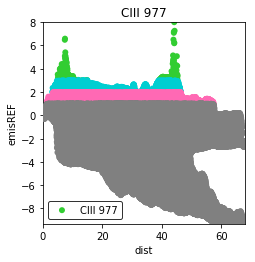

In [58]:
test_plot

## Connecting Emission and HI Properties

#### First, let's test out matching pixels from one frb to another. 

In [40]:
cmap = colors.ListedColormap(['Gray','HotPink','DarkTurquoise','Chartreuse'])
bounds = [-5,1,2,3,5]
norm = colors.BoundaryNorm(bounds,cmap.N)

In [70]:
data = cPickle.load(open('frbs/frbx_nref11_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emis = emis/(3.**4)
test = np.ma.masked_where((np.log10(emis) > 1.),emis)

/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


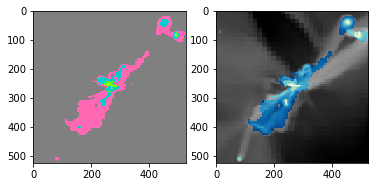

In [71]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='Greys_r',vmin=12,vmax=23)
ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
plt.show()

/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


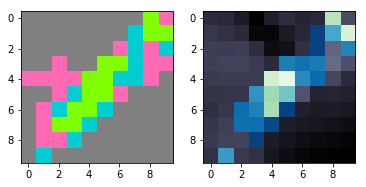

In [59]:
data = cPickle.load(open('frbs/frbx_nref11_RD0020_H_p0_number_density_10kpc.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_CIII_977_10kpc.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_OVI_forcedres.cpkl','rb'))
test = np.ma.masked_where((np.log10(emis) > 2.),emis)

fig,ax = plt.subplots(1,2)

ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='bone',vmin=12,vmax=23)
ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
plt.show()

Well now that I'm seeing these next to each other, I like them a lot less than I thought I would. Maybe if I try with the forced refinement it'll make more of an impact for me?

Ehh I'm still not really sure if these are necessary. Can show Molly and Jason though. At any rate, they could be interesting for a talk if not the paper.

/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


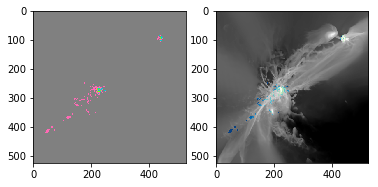

In [169]:
data = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emis = emis/(3.**4)
test = np.ma.masked_where((np.log10(emis) > 1.),emis)

fig,ax = plt.subplots(1,2)

out1 = ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
#plt.colorbar(out1)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='Greys_r',vmin=12,vmax=23)
out2 = ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
#plt.colorbar(out2)
plt.show()

/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


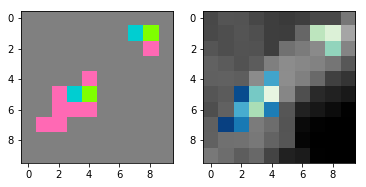

In [73]:
data = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_H_p0_number_density_10kpc.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_CIII_977_10kpc.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_OVI_10kpc.cpkl','rb'))
emis = emis/(3.**4)
test = np.ma.masked_where((np.log10(emis) > 1.),emis)

fig,ax = plt.subplots(1,2)

ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='Greys_r',vmin=12,vmax=23)
ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
plt.show()

:Layout
   .DynamicMap.I :DynamicMap   []
   .Points.I     :Points   [HI column,Emission]
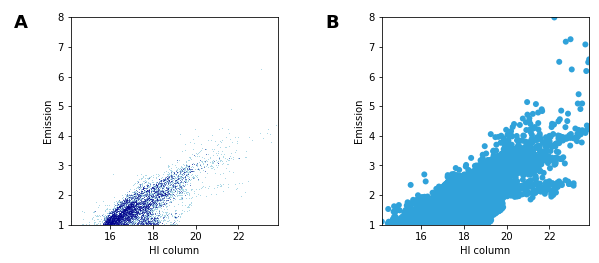

In [5]:
colHI = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
emisCIII = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
emisOVI = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emisCIII = np.log10(emisCIII/(3.**4))
emisOVI = np.log10(emisOVI/(3.**4))
colHI = np.log10(colHI)

iOVI = np.where(emisOVI >= 1.)
ptshereOVI = np.vstack((colHI[iOVI], emisOVI[iOVI])).T
iCIII = np.where(emisCIII >= 1.)
ptshereCIII = np.vstack((colHI[iCIII], emisCIII[iCIII])).T

pltOVI = hv.Points(ptshereOVI,kdims=['HI column','Emission'])#.opts(style=dict(alpha=0.4))
pltCIII = hv.Points(ptshereCIII,kdims=['HI column','Emission'])

datashade(pltCIII).opts(plot=dict(aspect='square')) + pltCIII

One thing that I could try to do is draw the contours, figure out ow to get them returned and then do a hybrid plot of shading within the contour and plotting the points that lie outside it.

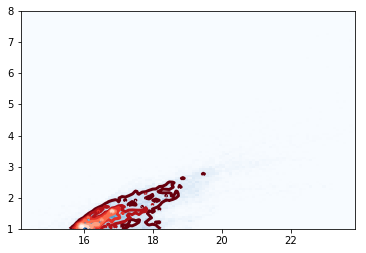

In [167]:
counts,ybins,xbins,image = plt.hist2d(colHI[iCIII],emisCIII[iCIII],bins=100,cmap='Blues')
tout = plt.contour(counts.T,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=3,cmap='Reds_r')
#plt.contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,color='red')

plt.show()

Buttt turns out getting those contours from matplotlib is so not easy. But in making emission pots for Jason, I refound code from my paper with David where I just used 2D histograms. If I pick a colorbar that doesn't end in white, even the low density points are shown.

/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


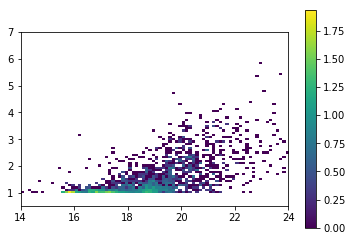

In [33]:
#colHI,emisOVI,emisCIII = colHI.flat,emisOVI.flat,emisCIII.flat
iOVI = np.where(emisOVI >= 1.)
colHIw,emisOVIw = colHI[iOVI],emisOVI[iOVI]
iCIII = np.where(emisCIII >= 1.)
colHIx,emisCIIIx = colHI[iCIII],emisCIII[iCIII]

hist, xedges, yedges  = np.histogram2d(colHIw,emisOVIw,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

In [20]:
print np.min(colHIx),np.max(colHI)
print np.min(emisCIIIx),np.max(emisCIIIx)

14.1436779464 23.8750746546
1.00002661963 7.99259277893


/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


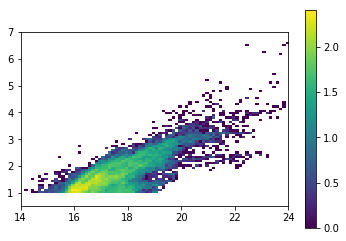

In [35]:
hist, xedges, yedges  = np.histogram2d(colHIx,emisCIIIx,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

In [42]:
colHIN = cPickle.load(open('frbs/frbx_nref11_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
emisCIIIN = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
emisOVIN = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emisCIIIN = np.log10(emisCIIIN/(3.**4))
emisOVIN = np.log10(emisOVIN/(3.**4))
colHIN = np.log10(colHIN)

colHIN,emisOVIN,emisCIIIN = colHIN.flat,emisOVIN.flat,emisCIIIN.flat
iOVIN = np.where(emisOVIN >= 1.)
colHIwN,emisOVIwN = colHIN[iOVIN],emisOVIN[iOVIN]
iCIIIN = np.where(emisCIIIN >= 1.)
colHIxN,emisCIIIxN = colHIN[iCIIIN],emisCIIIN[iCIIIN]

/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


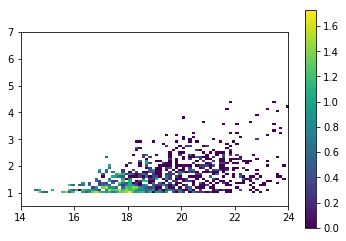

In [43]:
hist, xedges, yedges  = np.histogram2d(colHIwN,emisOVIwN,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

/Users/dalek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


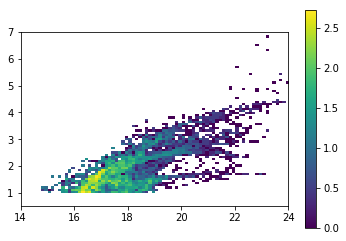

In [44]:
hist, xedges, yedges  = np.histogram2d(colHIxN,emisCIIIxN,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

In [45]:
ptshereOVIN = np.vstack((colHIN[iOVIN], emisOVIN[iOVIN])).T
ptshereCIIIN = np.vstack((colHIN[iCIIIN], emisCIIIN[iCIIIN])).T

pltOVIN = hv.Points(ptshereOVIN,kdims=['HI column','Emission'])#.opts(style=dict(alpha=0.4))
pltCIIIN = hv.Points(ptshereCIIIN,kdims=['HI column','Emission'])



:Layout
   .DynamicMap.I  :DynamicMap   []
   .DynamicMap.II :DynamicMap   []
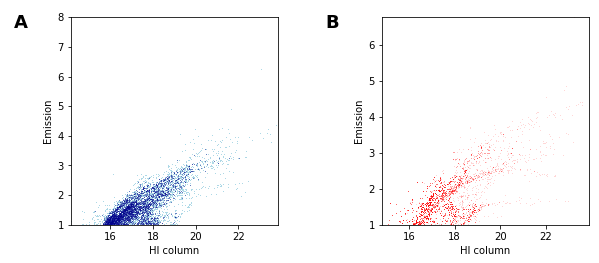

In [60]:
totalCIII = datashade(pltCIII).opts(plot=dict(aspect='square')) + datashade(pltCIIIN,cmap='red').opts(plot=dict(aspect='square'))
totalCIII.opts(plot=dict(figsize=[18,18]))

In [59]:
renderer = Store.renderers['matplotlib'].instance(fig='pdf',holomap='gif')
renderer.save(totalCIII,'emisCIII_vs_HI')

:DynamicMap   []
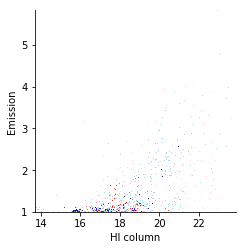

In [63]:
totalOVI = datashade(pltOVI).opts(plot=dict(aspect='square')) * datashade(pltOVIN,cmap='red').opts(plot=dict(aspect='square'))
totalOVI.opts(plot=dict(figsize=[18,18]))

In [108]:
id1= np.where(emisCIII > 1)[0]
id2 = np.where(emisCIIIN> 1)[0]

In [107]:
eCIII = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
eCIIIN = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))


(525, 525)


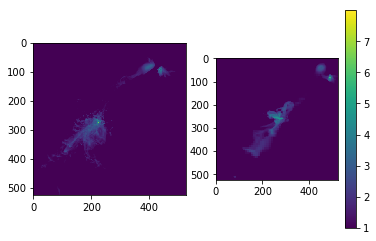

In [102]:
fig,ax = plt.subplots(1,2)
im1 = ax[0].imshow(np.log10(eCIII/(3**4)),vmin=1)
ax[1].imshow(np.log10(eCIIIN/(3**4)),vmin=1)
plt.colorbar(im1)
plt.show()


In [111]:
id1= np.where(eCIII > 1)[0]
id2 = np.where(eCIIIN> 1)[0]
print len(id1),len(id2)


157028 115624


In [112]:
print 115624./157028

0.736327279211
